In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA


def get_train_test(df):
  return train_test_split(df.loc[:, df.columns != "Outcome"], df["Outcome"], test_size = .3, random_state=57)


def score_data(scored_df_):
  X_train, X_test, y_train, y_test = get_train_test(scored_df_)
  model = LogisticRegression()
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  return confusion_matrix(y_test, predictions, labels=model.classes_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


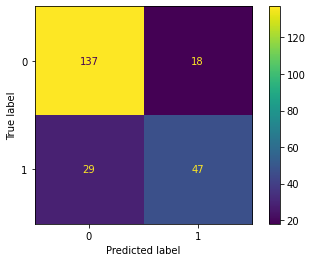

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/brook-miller/msai339-students/main/3-homework/diabetes.csv')
cm = score_data(df)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Before starting, I am going to give an overview of my work in this notebook. I am going to start by cleaning the data by finding missing values and replacing them. After that, I will be doing EDA on the data we have to find interesting insights that might help for feature engineering and model preparation. Finally, I will be doing the model prep and feature engineering.

An important point is that I will be using my own evaluation metrics as the given function might cause data leakage as it takes as input a full dataframe and the transforms applied might have been applied to the whole data which will cause data leakage. Optimally, all the transforms should be fit on the train data without seeing the test data, and the metrics should be calculated on the test data only.

We will focus mainly on improving the number of false negatives and the recall as in cases like detecting a major diabetes, it is very important to avoid false negatives.
We will also keep accuracy in mind, and we will set a threshold for the accuracy to be at least as good as the initial model without data handling and feature engineering.

# Data Cleaning


We will start by taking a high-level look at our data by using basic functions like info() and describe().



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We can see that the type of the data is proper and we don't need to cast it  or fix any of the column in anyway. Also, we don't see missing values based on the Non-Null Count values in df.info(), however, we will inspect this further by inspecting the data.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


We can see that measurements like Glucose, Insulin, BMI and Skin Tickness can't have values of 0, so we need to consider these as missing values and handle them acordingly.
In addition, we still can't look at the mean, median and quantile information as the data is still corrupted in this case.

In [ ]:
df.loc[df['Glucose'] == 0, 'Glucose'] = np.nan
df.loc[df['BloodPressure'] == 0, 'BloodPressure'] = np.nan
df.loc[df['SkinThickness'] == 0, 'SkinThickness'] = np.nan
df.loc[df['Insulin'] == 0, 'Insulin'] = np.nan
df.loc[df['BMI'] == 0, 'BMI'] = np.nan

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


This shows the true count for the missing values. We can see that we have a very big number of missing numbers for skinThickness and Insulin as compared to the others. So we will start by removing the outliers for the remaining columns because they are few and we will retain most of our dataset, and we will avoid adding bias in our data by choosing to impute the missing values in a certain way.

In [ ]:
df = df.dropna(subset=['Glucose', 'BloodPressure', 'BMI'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               724 non-null    int64  
 1   Glucose                   724 non-null    float64
 2   BloodPressure             724 non-null    float64
 3   SkinThickness             532 non-null    float64
 4   Insulin                   392 non-null    float64
 5   BMI                       724 non-null    float64
 6   DiabetesPedigreeFunction  724 non-null    float64
 7   Age                       724 non-null    int64  
 8   Outcome                   724 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 56.6 KB


For the remaining columns, we will try iterative, mean, KNN imputing, and mode imputing and select the imputation methods which dataset performs best with the metrics specified before.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


X_train, X_test, y_train, y_test = get_train_test(df)

train_pd = pd.concat([X_train, y_train], axis=1)

test_pd = pd.concat([X_test, y_test], axis=1)

iterative_imputers = [IterativeImputer(max_iter=i, random_state=0) for i in range(0, 30, 5)]
KNN_imputers = [KNNImputer(n_neighbors=i) for i in range(1, 11)]


for imp in [SimpleImputer(missing_values=np.nan, strategy='mean'), SimpleImputer(missing_values=np.nan, strategy='mean')] + iterative_imputers + KNN_imputers:
    print(imp)
    train = pd.concat([X_train, y_train], axis=1)

    test = pd.concat([X_test, y_test], axis=1)
    imp.fit(train)
    train = pd.DataFrame(imp.transform(train), columns=train.columns)

    model = LogisticRegression(max_iter=1000)
    model.fit(train.loc[:, train.columns != "Outcome"], train["Outcome"])

    test = pd.DataFrame(imp.transform(test), columns=test.columns)

    predictions = model.predict(test.loc[:, test.columns != "Outcome"])

    accuracy = (predictions == test["Outcome"]).sum() / len(test)

    false_negatives = (predictions == 0) & (test["Outcome"] == 1)
    false_negatives = false_negatives.sum()
    print(f"Accuracy: {accuracy}, False Negatives: {false_negatives} \n")


SimpleImputer()
Accuracy: 0.7752293577981652, False Negatives: 24 

SimpleImputer()
Accuracy: 0.7752293577981652, False Negatives: 24 

IterativeImputer(max_iter=0, random_state=0)
Accuracy: 0.7752293577981652, False Negatives: 24 

IterativeImputer(max_iter=5, random_state=0)
Accuracy: 0.7798165137614679, False Negatives: 24 

IterativeImputer(random_state=0)
Accuracy: 0.7798165137614679, False Negatives: 24 

IterativeImputer(max_iter=15, random_state=0)
Accuracy: 0.7798165137614679, False Negatives: 24 

IterativeImputer(max_iter=20, random_state=0)
Accuracy: 0.7798165137614679, False Negatives: 24 

IterativeImputer(max_iter=25, random_state=0)
Accuracy: 0.7798165137614679, False Negatives: 24 

KNNImputer(n_neighbors=1)
Accuracy: 0.7798165137614679, False Negatives: 24 

KNNImputer(n_neighbors=2)
Accuracy: 0.7798165137614679, False Negatives: 24 

KNNImputer(n_neighbors=3)
Accuracy: 0.7752293577981652, False Negatives: 24 

KNNImputer(n_neighbors=4)
Accuracy: 0.7752293577981652, F

We are getting 24 false negatives in the test set for all imputing methods. This could be due to the fact that most of the data in the test set has a very similar distribution that is centered around the mean which would make all imputing methods given return very similar values, which is causing a consistent performance for our logistic regression model.

Also, we will see later that the variables we are looking at have normal distribution (which is expected considering they are human measurements, which all tend to be normal), so the go-to imputing method would be imputing by the mean.
We went a step further here by examining other methods and checking how the model would perform when applying them. 

We will choose the simplest model with 0.7798 accuracy, which in this case would be the KNNInputer with 1 neighbor. It also makes sense to use this method as it looks at the closest data point and replaces the missing value for the missing variable with the value of the closest point for this same variable.

In [ ]:
imp = IterativeImputer(max_iter=5, random_state=0)
df.loc[:, df.columns != "Outcome"] = imp.fit_transform(df.loc[:, df.columns != "Outcome"])
main_df = df.copy(deep=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               724 non-null    float64
 1   Glucose                   724 non-null    float64
 2   BloodPressure             724 non-null    float64
 3   SkinThickness             724 non-null    float64
 4   Insulin                   724 non-null    float64
 5   BMI                       724 non-null    float64
 6   DiabetesPedigreeFunction  724 non-null    float64
 7   Age                       724 non-null    float64
 8   Outcome                   724 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 56.6 KB


We will proceed with the new df for the EDA section as we will be visualizing our whole data set and don't care about train-test partioning. Later when doing model prep and feature engineering, we will return to our original dataset and add the imputer to the pipeline.

# EDA

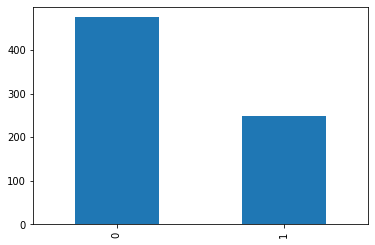

In [ ]:
df["Outcome"].value_counts().plot(kind='bar')

We can see that most people in the dataset don't have diabetes. Also, although the people who have diabetes are less, it is not a problem of "anomaly detection", because the data with outcome=1 is a considerable part of the dataset, and we won't have to handle our data as if the dataset was "imbalanced".

We will now plot the distributions of our variables using histograms.

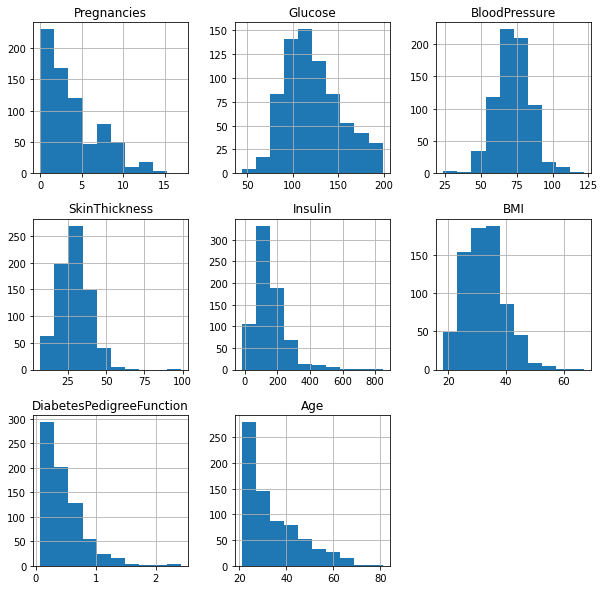

In [ ]:
df.drop("Outcome", axis=1).hist(figsize=(10,10))
plt.show()

We have features with normal distributions like glucose, bloodPressure, BMI (most of them are skewed to the left) while others have an exponential distribution like, Pregnancies, Diabetes Pedigree Function, and Age.
It is important to keep the distribution of the variables in mind when considering transforms later. 
In addition, I researched the normal values for the measurements used in the dataset, and the distributions above seem to be in line with the findings.
Also, a quick observation is that this study seems to focus more on the younger generation. It also takes into consideration many females with a higher than average number of pregnancies.

We are now going to look at box-plots of the variables to understand the distributions better, as well as see the outliers for the variables.


Pregnancies                    AxesSubplot(0.125,0.657941;0.227941x0.222059)
Glucose                     AxesSubplot(0.398529,0.657941;0.227941x0.222059)
BloodPressure               AxesSubplot(0.672059,0.657941;0.227941x0.222059)
SkinThickness                  AxesSubplot(0.125,0.391471;0.227941x0.222059)
Insulin                     AxesSubplot(0.398529,0.391471;0.227941x0.222059)
BMI                         AxesSubplot(0.672059,0.391471;0.227941x0.222059)
DiabetesPedigreeFunction          AxesSubplot(0.125,0.125;0.227941x0.222059)
Age                            AxesSubplot(0.398529,0.125;0.227941x0.222059)
dtype: object

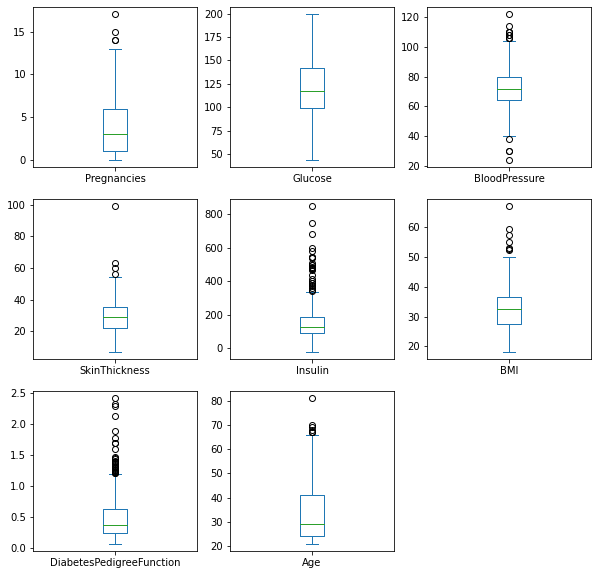

In [ ]:
df.drop("Outcome", axis=1).plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,10))

We can a lot of outliers in Insulin, DiabetesPedigreeFunction, BloodPressure and BMI. We have less in age and pregnancies, and close to None skinThickness and Glucose. It is important to consider outliers and how to detect them. We will look at this in the feature engineering section, however as a first intuition, it wouldn't make sense to remove the outliers, first because some features have many outliers and second because outliers in this case might help us capture predictions as we will see in the next graph. We will try to use transforms like Satndard or Power Transform later to deal with outliers, and see if it performs the perfomance of our logistic regression.

In the next cell, we will plot the average of each feature when the outcome is equal to 1 and when the outcome is equal to 0. This will help us understand how these features might be affecting the target variable. Features that have very different means for the 2 outcomes might be more significant. It is important to note that this is not always the case as there are many more advanced techniques to check for the important of the variables, but this visualization will help us understand the dynamic between the features and the target variable.

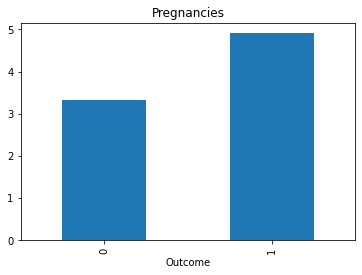

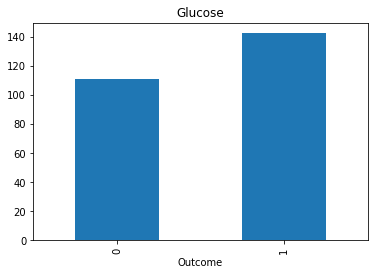

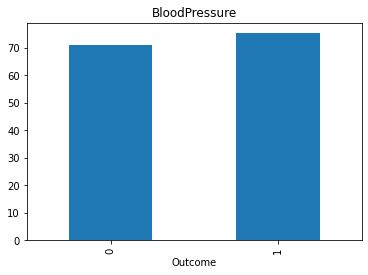

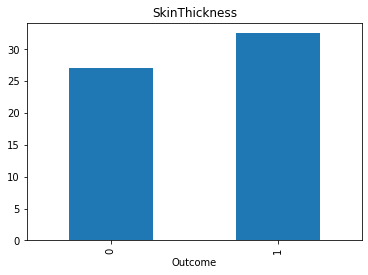

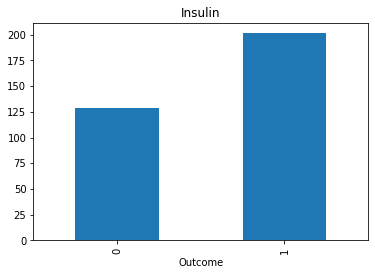

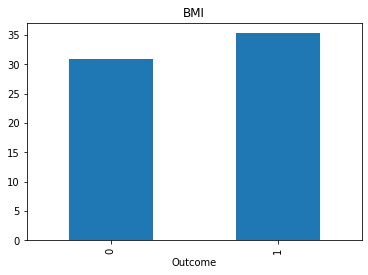

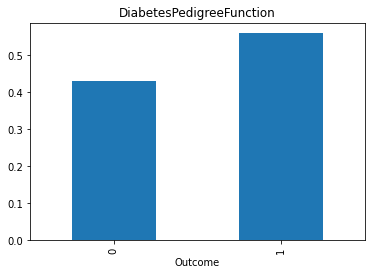

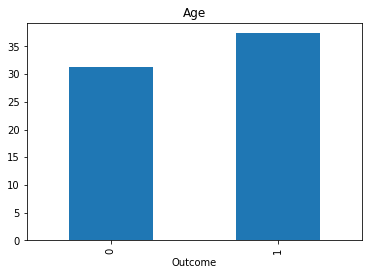

In [ ]:
for col in df.columns:
    if col == "Outcome":
        continue
    df.groupby("Outcome").mean()[col].plot(kind='bar')
    plt.title(col)
    plt.show()

We can see that insulin and pregnancies have very different means for outcome 0 and outcome 1 while other features Blood Pressure are not that different for both outcomes. We will use other techniques in the feature engineering section to look at the importance of our features.
We will examine pregnancies a little further. In this plot, we will see the mean outcome for every number of pregnancies.

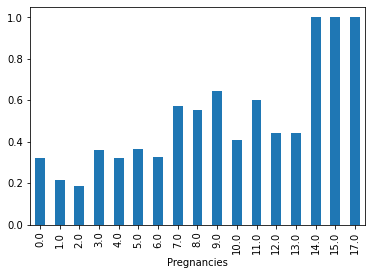

In [ ]:
df.groupby("Pregnancies").mean()["Outcome"].plot(kind='bar')

We can see that the general trend shows that a higher number of pregnancies result in a higher outcome. 

So far, we have examined at every variable by itself (or single variables with the outcome). We will now look at the relationship between the features, and at the relationships between those variables compared with the outcome.
Next, we are going to plot scatter plots for all variables against each other (except the target variable)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa37811d490>,
      dtype=object)

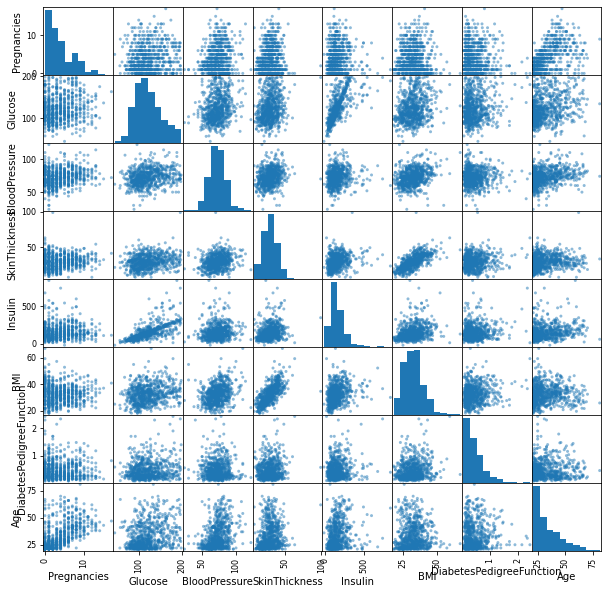

In [ ]:
pd.plotting.scatter_matrix(df.drop("Outcome", axis=1), figsize=(10,10))

BY quickly looking at the graphs, we don't really see any linear relationship between the features, except for Skin-Tickness and BMI which seem to be closely correlated, however the relationship doesn't seem to be completely linar (it is important to identify linear relationships as it can ruin the output of a regression, it has a closed form solution which requires X to be invertible). We should also keep in mind that we might need to introduce some non-linearity to the dataset by generating additional polynomial features (by combining variables up to a certain degree).
Next, we will plut a correlation matrix to quantify the relationship seen in the plot above.

In [ ]:
df.corr().style.background_gradient(cmap='coolwarm')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.134915,0.209668,0.103359,0.069566,0.012342,-0.025996,0.557066,0.224417
Glucose,0.134915,1.000000,0.223331,0.231655,0.691109,0.223276,0.136630,0.263560,0.488384
BloodPressure,0.209668,0.223331,1.000000,0.234163,0.130507,0.287403,-0.000075,0.324897,0.166703
SkinThickness,0.103359,0.231655,0.234163,1.000000,0.238461,0.697529,0.122621,0.145876,0.267640
Insulin,0.069566,0.691109,0.130507,0.238461,1.000000,0.262862,0.136008,0.206210,0.349774
BMI,0.012342,0.223276,0.287403,0.697529,0.262862,1.000000,0.154858,0.020835,0.299375
DiabetesPedigreeFunction,-0.025996,0.136630,-0.000075,0.122621,0.136008,0.154858,1.000000,0.023098,0.184947
Age,0.557066,0.263560,0.324897,0.145876,0.206210,0.020835,0.023098,1.000000,0.245741
Outcome,0.224417,0.488384,0.166703,0.267640,0.349774,0.299375,0.184947,0.245741,1.000000


As said before, we don't have extreme values for the coefficients in the matrix which proves further that we don't have linear relationships between the variables. The biggest value here is between BMI and skinThickness, however we can't get rid of either variables as they capture different realities and the correlation isn't worringly high. Combining them by doing EDA specifically on the 2 variables can be an option, if it improves the perfomance of our model. 
Also, we have considerably high correlation between Age and pregnancies, which is logical considering women who are older are more likely to have more pregnancies, and between Insuline and Glucose. 

We will continue by plotting all variables against each others and see the relationship of the data points with the outcome (by plotting variable x with variable y and having the "outcome" as the color of each data point, for x and y covering all features).


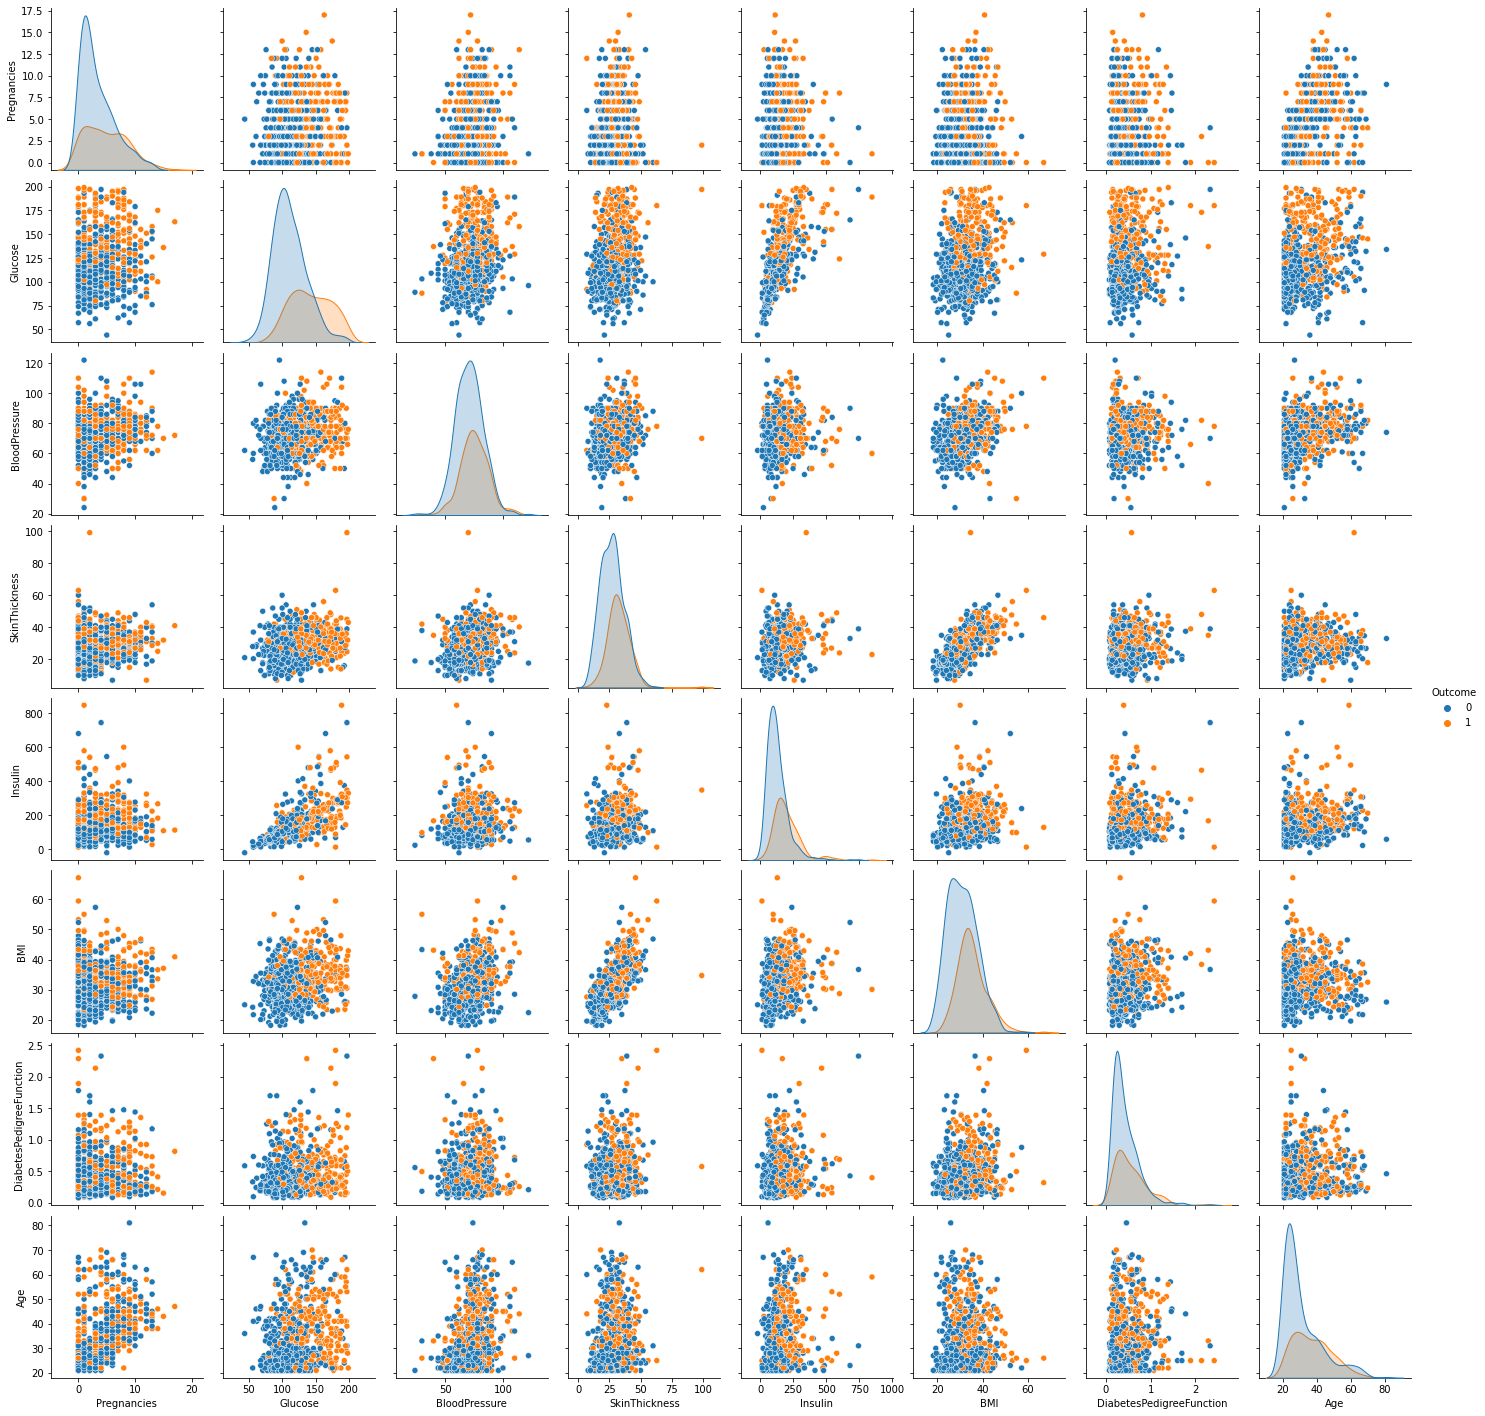

In [ ]:
sns.pairplot(df, hue='Outcome')

This is a very intersting graph, as it shows many relationships we hadn't seen before. In most graphs, we can see clusters of data in most combinations of pair of variables. We can create new variables by utilizing these, and linearly seperating data where clusters seem to be linear seperable. It will help the model capture the non-linearity of the data.
Looking at the pair of variables who are highly correlated, we can see that the graph of age-pregnancy doesn't have clearly linearly separable clusters, while the glucose-insuline and skinThickness-BMI have clearly linearly separable. We will take a look at that in the feature engineering section.
Also, it is important to introduce some feature engineering for non-linearity as regressions generally do a poor job in learning non-linearity in the data.

We will select 5 plots where clusters are very obvious and we will try to find where the separations seems to be strongest. 

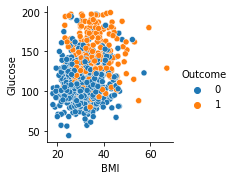

In [ ]:
sns.pairplot(df, x_vars=['BMI'], y_vars=['Glucose'], hue='Outcome')

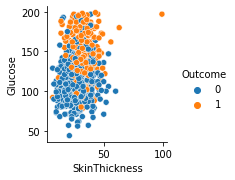

In [ ]:
sns.pairplot(df, x_vars=['SkinThickness'], y_vars=['Glucose'], hue='Outcome')

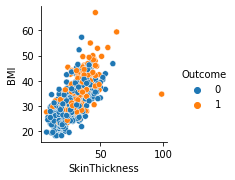

In [ ]:
sns.pairplot(df, x_vars=['SkinThickness'], y_vars=['BMI'], hue='Outcome')

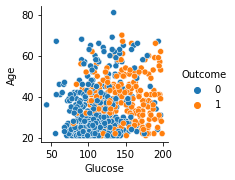

In [ ]:
sns.pairplot(df, x_vars=['Glucose'], y_vars=['Age'], hue='Outcome')

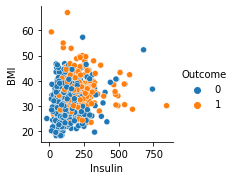

In [ ]:
sns.pairplot(df, x_vars=['Insulin'], y_vars=['BMI'], hue='Outcome')

First, we can see that in the first two figure as glucose level less than 120 seems to be generic for all healthy people. Also from each figure:


*   For figure 1, we will use a cluster of Glucose < 110 and BMI < 35.
*   For figure 2, we will use a cluster of Glucose < 120 (which seems to be generic as we said).
*   For figure 3, we will use a cluster of BMI < 30 and SkinThickness < 30.
*   For figure 4, we will use cluster of Glucose < 110 and Age < 35.
*   For figure 5, we will use cluster of Insuline > 250 and Age > 30.

We will use the extracted insight in the feature engineering section.





We will now move to the feature engineering section to apply the extracted insights.

# Feature Engineering

We will start by looking at the potential transforms that could be applied to our data to fix the distributions to better fit the need of our regression model and take care of the outliers.
We will try multiple of tranforms even though we know some might not work as well as others (Standard will perform better than Normalizer because most of the features have a normal distribution), we will let the metrics be the basis of our decisions.

We will re-extract the df from main_df and remember to use the imputer at the beginning of our pipeline.

In [ ]:
df = main_df.copy(deep=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               724 non-null    float64
 1   Glucose                   724 non-null    float64
 2   BloodPressure             724 non-null    float64
 3   SkinThickness             724 non-null    float64
 4   Insulin                   724 non-null    float64
 5   BMI                       724 non-null    float64
 6   DiabetesPedigreeFunction  724 non-null    float64
 7   Age                       724 non-null    float64
 8   Outcome                   724 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 56.6 KB


In [ ]:
X_train, X_test, y_train, y_test = get_train_test(df)

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

print("Base Logistic Regression Model")
model = Pipeline(steps=[("imputer", IterativeImputer(max_iter=5)), ('model', LogisticRegression(max_iter=1000))])
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, predictions)))
false_negatives = (predictions == 0) & (y_test == 1)
false_negatives = false_negatives.sum()
print("False Negatives: {}".format(false_negatives))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))
print("")

scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), Normalizer(), QuantileTransformer(), PowerTransformer()]
for scaler in scalers:
    model = Pipeline(steps=[("imputer", IterativeImputer(max_iter=10, random_state=0)), ("scaler", scaler), ('model', LogisticRegression(max_iter=1000))])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(scaler)
    print("Accuracy: {}".format(accuracy_score(y_test, predictions)))
    false_negatives = (predictions == 0) & (y_test == 1)
    false_negatives = false_negatives.sum()
    print("False Negatives: {}".format(false_negatives))
    print("Precision: {}".format(precision_score(y_test, predictions)))
    print("Recall: {}".format(recall_score(y_test, predictions)))
    print("")

Base Logistic Regression Model
Accuracy: 0.7752293577981652
False Negatives: 24
Precision: 0.6376811594202898
Recall: 0.6470588235294118

StandardScaler()
Accuracy: 0.7798165137614679
False Negatives: 24
Precision: 0.6470588235294118
Recall: 0.6470588235294118

MinMaxScaler()
Accuracy: 0.7935779816513762
False Negatives: 26
Precision: 0.6885245901639344
Recall: 0.6176470588235294

RobustScaler()
Accuracy: 0.7798165137614679
False Negatives: 24
Precision: 0.6470588235294118
Recall: 0.6470588235294118

MaxAbsScaler()
Accuracy: 0.7935779816513762
False Negatives: 26
Precision: 0.6885245901639344
Recall: 0.6176470588235294

Normalizer()
Accuracy: 0.6697247706422018
False Negatives: 51
Precision: 0.4473684210526316
Recall: 0.25

QuantileTransformer()
Accuracy: 0.7660550458715596
False Negatives: 27
Precision: 0.6307692307692307
Recall: 0.6029411764705882

PowerTransformer()
Accuracy: 0.7752293577981652
False Negatives: 24
Precision: 0.6376811594202898
Recall: 0.6470588235294118



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (506). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)


We will add StandardScaler to our pipeline because it improved the accuracy of our model by a very small margin, while still having the sam enumber of false negatives. 

We will now try to look at the importances ofour features based on models like Logistic Regression and decision trees.

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

X_trai, X_test, y_train, y_test = get_train_test(df)

pipeline =  Pipeline(steps=[("imputer", IterativeImputer(max_iter=10, random_state=0)), ('scaler', StandardScaler())])
X_train = pipeline.fit_transform(X_trai)
X_train = pd.DataFrame(X_train, columns=X_trai.columns)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print("Logistic Regression Coefficients")
coefficients = dict(zip(df.columns, model.coef_[0]))
coefficients = {k: v for k, v in sorted(coefficients.items(), key=lambda item: abs(item[1]), reverse=True)}
print(coefficients)
print("")


model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print("Decision Tree Coefficients")
feature_importance = dict(zip(X_train.columns, model.feature_importances_))
feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
print(feature_importance)
print("")


model = RandomForestClassifier()
model.fit(X_train, y_train)
print("Random Forest Feature Importances")
feature_importance = dict(zip(X_train.columns, model.feature_importances_))
feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}
print(feature_importance)
print("")

Logistic Regression Coefficients
{'Glucose': 1.057934359443648, 'BMI': 0.5854583372945367, 'Pregnancies': 0.3851778276693274, 'DiabetesPedigreeFunction': 0.38220278390918333, 'BloodPressure': -0.18621539541095902, 'Age': 0.17004250398081, 'SkinThickness': 0.0668216201316682, 'Insulin': 0.01977496437413633}

Decision Tree Coefficients
{'Glucose': 0.24460823207545052, 'DiabetesPedigreeFunction': 0.14055998131763509, 'Age': 0.1346212537241278, 'BMI': 0.13409441473366665, 'Insulin': 0.1282907607144728, 'SkinThickness': 0.0755833986289167, 'BloodPressure': 0.0736314066092178, 'Pregnancies': 0.06861055219651255}
Random Forest Feature Importances
{'Glucose': 0.18798202361470331, 'Insulin': 0.17308590864175152, 'BMI': 0.14315657557207417, 'Age': 0.1343138801744476, 'DiabetesPedigreeFunction': 0.12734758393778162, 'SkinThickness': 0.09806620923677445, 'BloodPressure': 0.07354867162371806, 'Pregnancies': 0.062499147198749244}



Insulin seems to be of low importance for the regression, and Pregnancies and Blood pressure seems to be of low importance for our tree models.
We will try to drop these features one by one and see if our model will improve. The anticipated result is a decrease in performance as the dataset already has a low number of columns, but we will try nevertheless. 

In [ ]:
no_pressure_df = df.drop(columns=['BloodPressure'])
no_preg_df = df.drop(columns=['Pregnancies'])
no_insulin_df = df.drop(columns=['Insulin'])

info_string =  ["Dropped Pressure",  "Dropped Pregnancies", "Dropped Insulin"]

for i, chosen_df in enumerate([no_pressure_df, no_preg_df, no_insulin_df]):
    X_train, X_test, y_train, y_test = get_train_test(chosen_df)
    model = Pipeline(steps=[("imputer", IterativeImputer(max_iter=10, random_state=0)), ("scaler", StandardScaler()), ('model', LogisticRegression(max_iter=1000))])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(info_string[i])
    print("Accuracy: {}".format(accuracy_score(y_test, predictions)))
    false_negatives = (predictions == 0) & (y_test == 1)
    false_negatives = false_negatives.sum()
    print("False Negatives: {}".format(false_negatives))
    print("Precision: {}".format(precision_score(y_test, predictions)))
    print("Recall: {}".format(recall_score(y_test, predictions)))
    print("")


Dropped Pressure
Accuracy: 0.7889908256880734
False Negatives: 23
Precision: 0.6617647058823529
Recall: 0.6617647058823529

Dropped Pregnancies
Accuracy: 0.8073394495412844
False Negatives: 23
Precision: 0.703125
Recall: 0.6617647058823529

Dropped Insulin
Accuracy: 0.7798165137614679
False Negatives: 24
Precision: 0.6470588235294118
Recall: 0.6470588235294118



Dropping the number of pregnancies gave us a better result for the accuracy and les number of false negatives, so we will drop it from our dataset and proceed.

In [ ]:
df = df.drop(columns=['Pregnancies'])

One last thing we will try to do is to create 5 new features as described in the last section of the EDA. 
We will reprint the conclusions of the figure here:

For figure 1, we will use a cluster of Glucose < 110 and BMI < 35.
For figure 2, we will use a cluster of Glucose < 120 (which seems to be generic as we said).
For figure 3, we will use a cluster of BMI < 30 and SkinThickness < 30.
For figure 4, we will use cluster of Glucose < 110 and Age < 35.
For figure 5, we will use cluster of Insuline > 250 and Age > 30.

In [ ]:
df["new_feature_1"] = (df["Glucose"] < 110) & (df["BMI"] < 35)
df["new_feature_2"] = (df["Glucose"] < 120)
df["new_feature_3"] = ((df["BMI"] < 30) & (df["SkinThickness"] < 30))
df["new_feature_4"] = (df["Glucose"] < 110) & (df["Age"] < 35)
df["new_feature_5"] = (df["Insulin"] > 250) & (df["Age"] > 30)
df.drop(columns=["Glucose"])

Technically, we now have Glucose_over_120 as a binary value (2 bins) instead of a continuous value)

In [ ]:
X_train, X_test, y_train, y_test = get_train_test(df)
model = Pipeline(steps=[("imputer", IterativeImputer(max_iter=10, random_state=0)), ("scaler", StandardScaler()), ('model', LogisticRegression(max_iter=1000))])
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("With New Features")
print("Accuracy: {}".format(accuracy_score(y_test, predictions)))
false_negatives = (predictions == 0) & (y_test == 1)
false_negatives = false_negatives.sum()
print("False Negatives: {}".format(false_negatives))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))
print("")

With New Features
Accuracy: 0.7706422018348624
False Negatives: 24
Precision: 0.6285714285714286
Recall: 0.6470588235294118



This doesn't improve our model, so ultimately, our best model is the one with the previous pipeline and the dropped pregnancies.

# Model

These are the metrics of our best model with the following pipeline: "Pipeline(steps=[("imputer", IterativeImputer(max_iter=10, random_state=0)), ("scaler", StandardScaler()), ('model', LogisticRegression(max_iter=1000))])" and with "Pregnancies" dropped:


*   Accuracy: 0.8073394495412844
*   False Negatives: 23
*   Precision: 0.703125
*   Recall: 0.6617647058823529


As a comparaison, this is our first valid model after finding the missing corrupt data and adding an imputer to the pipeline:

*   Accuracy: 0.7752293577981652
*   False Negatives: 24
*   Precision: 0.6376811594202898
*   Recall: 0.6470588235294118

Thus, we found some improvements in all the metrics, which shows that the feature engineering we did was useful.


It does not make sense to compare this model to the initial data which we used to generate the confusion matrix, because it included corrupt data (0 for body measurements that can't be 0), and its results can't be taken into consideration as it would be based on false assumptions and bad data. That's why I am using it a base Logistic Regression model to compare.

We will merge the transformed X_train and X_test in a dataset to generate a confusion matrix for the sake of the problem, although this might (and will most probably cause) data leakage.

In [ ]:
df = main_df.copy(deep=True)

In [ ]:
print("First Valid Model")
X_train, X_test, y_train, y_test = get_train_test(df)
model = Pipeline(steps=[("imputer", IterativeImputer(max_iter=10, random_state=0))])
X_train = model.fit_transform(X_train)
X_test = model.transform(X_test)

X_train = pd.DataFrame(X_train)
X_train['Outcome'] = list(y_train)

X_test = pd.DataFrame(X_test)
X_test['Outcome'] = list(y_test)

new_df = pd.concat([X_train, X_test])

score_data(new_df)

First Valid Model


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


array([[119,  26],
       [ 24,  49]])

In [ ]:
print("Last Model")
X_train, X_test, y_train, y_test = get_train_test(df.drop(columns=["Pregnancies"]))
model = Pipeline(steps=[("imputer", IterativeImputer(max_iter=10, random_state=0)), ("scaler", StandardScaler())])
X_train = model.fit_transform(X_train)
X_test = model.transform(X_test)

X_train = pd.DataFrame(X_train)
X_train['Outcome'] = list(y_train)

X_test = pd.DataFrame(X_test)
X_test['Outcome'] = list(y_test)

new_df = pd.concat([X_train, X_test])

score_data(new_df)

Last Model


array([[122,  23],
       [ 24,  49]])

We can see the improvements between the 2 models after adding the standard scaler and dropping the pregnancies. Compared to the initial confusion matrix that was shown at the beginning of the notebook, this is performing worse but again, the data at the beginning was corrupted so the result we got should be ignored and our new model should be compared to the baseline model with valid data, which is shown 2 cells above.

# Leakage Assessment

I have already talked about data leakage at the beginning and explained why I used my own metrics after dividing the data between train and test data. In fact, I build an initial pipeline and tried to add more components to it, and the pipeline is fit only on the train data with no regards no test data. The test data is then used for predictions and for later generating the metrics used.

Leakage would have happened if I had fit_transform-ed the whole dataset in one go, and then applied the logistic regression. This would have caused all the transforms to learn on the whole dataset, which includes the test set, and hence learn from the test set. This is will never happen in the real world, in a deployed model for example, as the new data has only access to pipeline it goes through, and the pipeline would see the data for the first time.

For this reason, I made sure to work with sklearn's pipeline and to train the pipeline on the training data only, and predict on the test data

One other possible instance of data leakage, is at the end of the model section when I merged the dataset and used the score_data function, there might be a different division of train and testing data in the pipeline used to train and fit, and the train and testing data used for the model in the function. However, this is not a big issue in this case, as the results are consistent to what was shown when I was using my own metrics and was working on clear training and testing data. Also, this was only used at the end to show the confusion matrix, and everything else was done neatly.

# Advanced EDA (added this section based on Dr. Miller's recommendation)

In [ ]:
X_train, X_test, y_train, y_test = get_train_test(df)
model = Pipeline(steps=[("imputer", IterativeImputer(max_iter=10, random_state=0)), ('scaler', StandardScaler()), ('poly', PolynomialFeatures(2)), ('model', LogisticRegression(max_iter=1000))])

model.fit(X_train, y_train) 
predictions = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, predictions)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))
false_negatives = (predictions == 0) & (y_test == 1)
false_negatives = false_negatives.sum()
print("False Negatives: {}".format(false_negatives))
print("")

Accuracy: 0.7018348623853211
Precision: 0.5211267605633803
Recall: 0.5441176470588235
False Negatives: 31



In [ ]:
X_train, X_test, y_train, y_test = get_train_test(df)
model = Pipeline(steps=[("imputer", IterativeImputer(max_iter=10, random_state=0)), ('scaler', StandardScaler()), ('poly', PolynomialFeatures(3)), ('model', LogisticRegression(max_iter=1000))])

model.fit(X_train, y_train) 
predictions = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, predictions)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))
false_negatives = (predictions == 0) & (y_test == 1)
false_negatives = false_negatives.sum()
print("False Negatives: {}".format(false_negatives))
print("")

Accuracy: 0.7110091743119266
Precision: 0.5301204819277109
Recall: 0.6470588235294118
False Negatives: 24



Both of the transforms have decreased the performance of our model, and it is mainly because we have too many columns (the number of columns grows exponentially when applying Polynomial Features). We will finalize by trying 2 dimensionality reduction algorithms to improve the perfomance of our model (PCA and SelectKBest).

In [ ]:
X_train, X_test, y_train, y_test = get_train_test(df)


for i in range(5, 50, 5):
  model = Pipeline(steps=[("imputer", IterativeImputer(max_iter=10, random_state=0)), ('scaler', StandardScaler()), ('poly', PolynomialFeatures(3)), ('KBest', SelectKBest(k=i)), ('model', LogisticRegression(max_iter=1000))])

  model.fit(X_train, y_train) 
  predictions = model.predict(X_test)
  print("select {}-best".format(i))
  print("Accuracy: {}".format(accuracy_score(y_test, predictions)))
  print("Precision: {}".format(precision_score(y_test, predictions)))
  print("Recall: {}".format(recall_score(y_test, predictions)))
  false_negatives = (predictions == 0) & (y_test == 1)
  false_negatives = false_negatives.sum()
  print("False Negatives: {}".format(false_negatives))
  print("")


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/li

select 5-best
Accuracy: 0.7844036697247706
Precision: 0.6666666666666666
Recall: 0.6176470588235294
False Negatives: 26

select 10-best
Accuracy: 0.7614678899082569
Precision: 0.6212121212121212
Recall: 0.6029411764705882
False Negatives: 27

select 15-best
Accuracy: 0.7477064220183486
Precision: 0.5942028985507246
Recall: 0.6029411764705882
False Negatives: 27



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


select 20-best
Accuracy: 0.7568807339449541
Precision: 0.6086956521739131
Recall: 0.6176470588235294
False Negatives: 26

select 25-best
Accuracy: 0.7660550458715596
Precision: 0.6231884057971014
Recall: 0.6323529411764706
False Negatives: 25



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


select 30-best
Accuracy: 0.7522935779816514
Precision: 0.6
Recall: 0.6176470588235294
False Negatives: 26

select 35-best
Accuracy: 0.7614678899082569
Precision: 0.6212121212121212
Recall: 0.6029411764705882
False Negatives: 27



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


select 40-best
Accuracy: 0.7431192660550459
Precision: 0.5882352941176471
Recall: 0.5882352941176471
False Negatives: 28

select 45-best
Accuracy: 0.7431192660550459
Precision: 0.5909090909090909
Recall: 0.5735294117647058
False Negatives: 29



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
X_train, X_test, y_train, y_test = get_train_test(df)


for i in range(5, 50, 5):
  model = Pipeline(steps=[("imputer", IterativeImputer(max_iter=10, random_state=0)), ('scaler', StandardScaler()), ('poly', PolynomialFeatures(3)), ('PCA', PCA(n_components=i)), ('model', LogisticRegression(max_iter=1000))])

  model.fit(X_train, y_train) 
  predictions = model.predict(X_test)
  print("select {}-best".format(i))
  print("Accuracy: {}".format(accuracy_score(y_test, predictions)))
  print("Precision: {}".format(precision_score(y_test, predictions)))
  print("Recall: {}".format(recall_score(y_test, predictions)))
  false_negatives = (predictions == 0) & (y_test == 1)
  false_negatives = false_negatives.sum()
  print("False Negatives: {}".format(false_negatives))
  print("")


select 5-best
Accuracy: 0.7477064220183486
Precision: 0.696969696969697
Recall: 0.3382352941176471
False Negatives: 45

select 10-best
Accuracy: 0.8073394495412844
Precision: 0.7708333333333334
Recall: 0.5441176470588235
False Negatives: 31

select 15-best
Accuracy: 0.7935779816513762
Precision: 0.7346938775510204
Recall: 0.5294117647058824
False Negatives: 32

select 20-best
Accuracy: 0.7889908256880734
Precision: 0.7115384615384616
Recall: 0.5441176470588235
False Negatives: 31

select 25-best
Accuracy: 0.7752293577981652
Precision: 0.6862745098039216
Recall: 0.5147058823529411
False Negatives: 33

select 30-best
Accuracy: 0.7798165137614679
Precision: 0.6724137931034483
Recall: 0.5735294117647058
False Negatives: 29

select 35-best
Accuracy: 0.7798165137614679
Precision: 0.6612903225806451
Recall: 0.6029411764705882
False Negatives: 27

select 40-best
Accuracy: 0.7798165137614679
Precision: 0.6724137931034483
Recall: 0.5735294117647058
False Negatives: 29

select 45-best
Accuracy: 0

It is obvious that the results are worse that what we previously had so we will stick to our previous model.